<a href="https://colab.research.google.com/github/thanhdatnguyentk/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-TensorFlow/blob/main/SCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Aug 10 12:21:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              46W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 72.5 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [5]:
print(tf.__version__)

2.17.0


In [6]:
if tf.test.gpu_device_name():
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!python3 -m pip install tensorflow[and-cuda]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 84.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not curr

# Data handling


## Loading data

In [8]:
!pip install pandas


###Extracting data

In [10]:
  #extracting data

import zipfile
with zipfile.ZipFile('/content/sample_data/SCV_data/data_test.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/SCV_data/data_test')

with zipfile.ZipFile('/content/sample_data/SCV_data/data_train.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/SCV_data/data_train')



###Process Data


####Train_data

In [11]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine

data = '/content/sample_data/SCV_data/data_train/data_train/train'

#create new dataframe with 2 columns (text and label)

#crteate a json to store the data
dem = 0
json = {'text': [], 'label': []}
df = pd.DataFrame(
    {'text': json['text'],
     'label': json['label']
    })

for file_text in os.listdir(data + '/neg'):
    with open(data + '/neg/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '0'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)

for file_text in os.listdir(data + '/pos'):
    with open(data + '/pos/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '1'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)


print(json)


print(df.head())

#save the dataframe to a csv file
df.to_csv('/content/sample_data/train.csv', index=False)




Streaming output truncated to the last 5000 lines.
25008
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
25083
25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095
25096
25097
25098
25099
25100
25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
2

####Test_data


In [12]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine

data = '/content/sample_data/SCV_data/data_train/data_train/test'

#create new dataframe with 2 columns (text and label)

#crteate a json to store the data
dem = 0
json = {'text': [], 'label': []}
df = pd.DataFrame(
    {'text': json['text'],
     'label': json['label']
    })

for file_text in os.listdir(data + '/neg'):
    with open(data + '/neg/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '0'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)

for file_text in os.listdir(data + '/pos'):
    with open(data + '/pos/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '1'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)


print(json)


print(df.head())

#save the dataframe to a csv file
df.to_csv('/content/sample_data/test.csv', index=False)

Streaming output truncated to the last 5000 lines.
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197

####Validation_data


In [13]:
import os
import sys
import pandas as pd
from sqlalchemy import create_engine

data = '/content/sample_data/SCV_data/data_test/data_test/test'

#create new dataframe with 2 columns (text and label)

#crteate a json to store the data
dem = 0
json = {'text': [], 'label': []}
df = pd.DataFrame(
    {'text': json['text'],
     'label': json['label']
    })

for file_text in os.listdir(data + '/neg'):
    with open(data + '/neg/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '0'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)

for file_text in os.listdir(data + '/pos'):
    with open(data + '/pos/' + file_text, 'r', encoding='utf-8') as file:
        text = file.read()
        json = {'text': [text], 'label': '1'}
        df_neg = pd.DataFrame(
            {'text': json['text'],
             'label': json['label']
            })
        df = pd.concat([df, df_neg])
        dem += 1
        print(dem)


print(json)


print(df.head())

#save the dataframe to a csv file
df.to_csv('/content/sample_data/validation.csv', index=False)

Streaming output truncated to the last 5000 lines.
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197

###Remove icon


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import shutil
import string

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_url(text):
    url_pattern  = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return url_pattern.sub(r'', text)
 # converting return value from list to string



def clean_text(text ):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))])

    return text2.lower()

train_data= pd.read_csv("/content/sample_data/train.csv")
train_data.dropna(axis = 0, how ='any',inplace=True)
train_data['Num_words_text'] = train_data['text'].apply(lambda x:len(str(x).split()))
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]
print('-------Train data--------')
print(train_data['label'].value_counts())
print(len(train_data))
print('-------------------------')
max_train_sentence_length  = train_data['Num_words_text'].max()


train_data['text'] = train_data['text'].apply(remove_emoji)
train_data['text'] = train_data['text'].apply(remove_url)
train_data['text'] = train_data['text'].apply(clean_text)


test_data= pd.read_csv("/content/sample_data/test.csv")
test_data.dropna(axis = 0, how ='any',inplace=True)
test_data['Num_words_text'] = test_data['text'].apply(lambda x:len(str(x).split()))

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['label'].value_counts())
print(len(test_data))
print('-------------------------')

test_data['text'] = test_data['text'].apply(remove_emoji)
test_data['text'] = test_data['text'].apply(remove_url)
test_data['text'] = test_data['text'].apply(clean_text)

#validation
val_data= pd.read_csv("/content/sample_data/validation.csv")
val_data.dropna(axis = 0, how ='any',inplace=True)
val_data['Num_words_text'] = val_data['text'].apply(lambda x:len(str(x).split()))
mask = val_data['Num_words_text'] >2
val_data = val_data[mask]

print('-------Validation data--------')
print(val_data['label'].value_counts())
print(len(val_data))
print('-------------------------')

val_data['text'] = val_data['text'].apply(remove_emoji)
val_data['text'] = val_data['text'].apply(remove_url)
val_data['text'] = val_data['text'].apply(clean_text)




print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))
print('Validation Max Sentence Length :'+str(val_data['Num_words_text'].max()))


#save the dataframe to a csv file
train_data.to_csv('/content/sample_data/train.csv', index=False)
test_data.to_csv('/content/sample_data/test.csv', index=False)
val_data.to_csv('/content/sample_data/validation.csv', index=False)

-------Train data--------
label
0    15000
1    15000
Name: count, dtype: int64
30000
-------------------------
-------Test data--------
label
0    5000
1    5000
Name: count, dtype: int64
10000
-------------------------
-------Validation data--------
label
0    5000
1    5000
Name: count, dtype: int64
10000
-------------------------
Train Max Sentence Length :1879
Test Max Sentence Length :2433
Validation Max Sentence Length :1228


###Change fomat for tensorflow


In [15]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['text'].tolist())

print(str(tokenizer.texts_to_sequences(['huhu hno review xong thèm quá hnay đây gọi đĩa khoai rán nem cốc nhântrần hết những 140k oimeoi giá mới tăng lúcnào hem biết khoai hnay rán quá nhiều miếng dầumỡ dãman luôn miếng rán chín quá cứngđờ xong rán qua tườngan rồi giờ rán lại kiểu ngon nem thì vẫn thế hnay hơi chua xíu nhưng vẫn ngon được nhântrần thì siêu ngon mát đợt tươngớt ngọt hơn bạn nào được xin thêm quất vắt nha xong hnay bđầu chăcs phải lâu nữa mới dám quay lại tiếp hic'])))


[[1344, 1, 331, 103, 230, 28, 919, 11, 42, 291, 610, 736, 709, 383, 7927, 57, 95, 3002, 6567, 37, 40, 1026, 410, 2412, 89, 610, 919, 736, 28, 24, 143, 1329, 998, 32, 143, 736, 693, 28, 8535, 103, 736, 70, 1, 41, 186, 736, 13, 125, 6, 709, 4, 85, 382, 919, 30, 295, 476, 10, 85, 6, 15, 7927, 4, 217, 6, 188, 914, 965, 88, 52, 21, 64, 15, 293, 59, 841, 1724, 148, 103, 919, 1, 10385, 45, 106, 39, 40, 533, 80, 13, 419, 968]]


In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.1,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

x_train = tokenizer.texts_to_sequences(X_train)
x_valid = tokenizer.texts_to_sequences(X_valid)
x_test  = tokenizer.texts_to_sequences(test_data['text'].tolist())

x_train = pad_sequences(x_train, padding='post', maxlen=2500)
x_valid = pad_sequences(x_valid, padding='post', maxlen=2500)
x_test = pad_sequences(x_test, padding='post', maxlen=2500)

x_train = np.array(x_train)
x_valid = np.array(x_valid)
x_test  = np.array(x_test)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['label'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:27000
Class distributionCounter({1: 13500, 0: 13500})
Valid data len:3000
Class distributionCounter({0: 1500, 1: 1500})
[ 47 234  11 ...   0   0   0]


In [17]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[1, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Text to number
[1 1 0 1 0 1 0 0 1 1]
Number to category
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [18]:
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==3:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==3:
        break
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==3:
        break

Streaming output truncated to the last 5000 lines.
tf.Tensor([231 194 145 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([810  25  40 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([45 55 11 ...  0  0  0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([1414   37  115 ...    0    0    0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([133 273  78 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([198  22 194 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([  3 104 114 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([613  15  63 ...   0   0   0], shape=(2500,), dtype=int32) tf.Tensor([0. 1.], shape=(2,), dtype=float64)
tf.Tensor([ 343  157 1405 ...

# Model


In [19]:
max_features =23000
embedding_dim =64
sequence_length = 2000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))

model.add(tf.keras.layers.Conv1D(128,3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))



model.build(input_shape=(None, sequence_length))
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 2000, 64)            │       1,472,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1998, 128)           │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,497,026 (5.71 MB)

 Trainable params: 1,497,026 (5.71 MB)

 Non-trainable params: 0 (0.00 B)

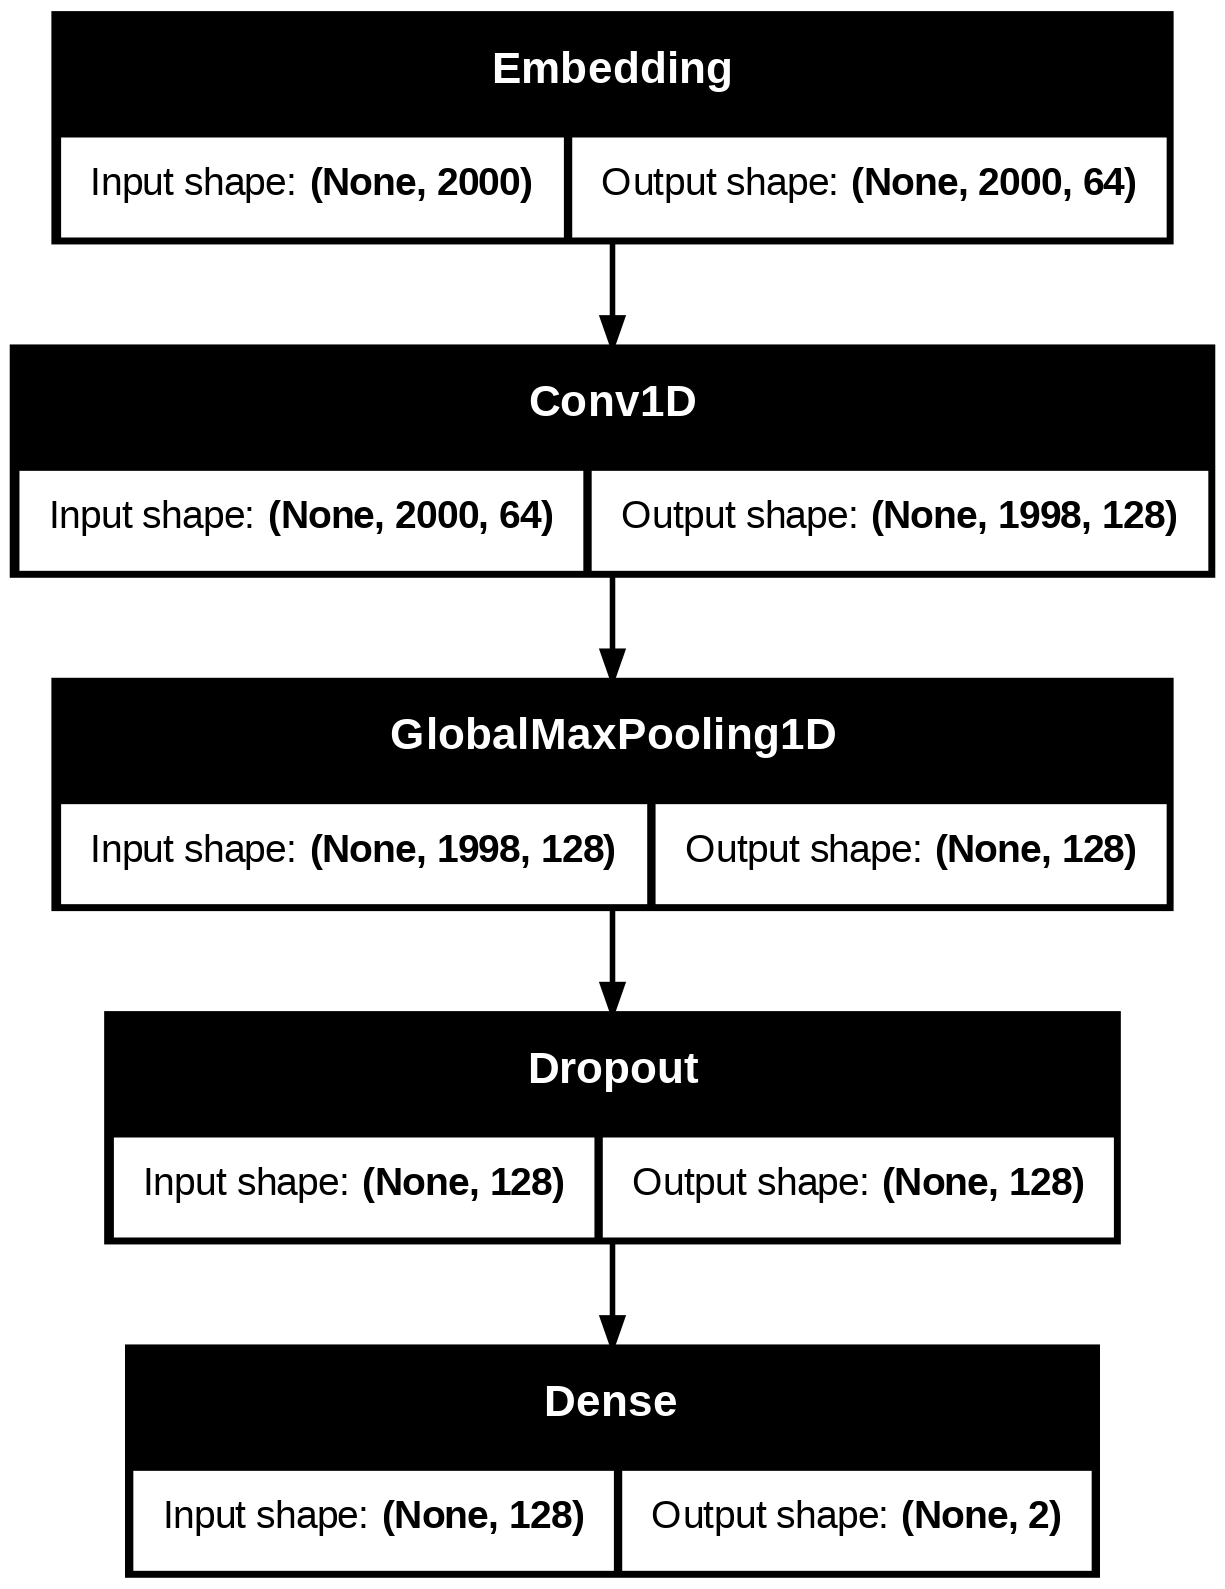

In [20]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

###another

In [23]:
max_features = 23000
embedding_dim = 64
sequence_length = 2000

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features + 1, embedding_dim, input_length=sequence_length,
                                   embeddings_regularizer=regularizers.l2(0.001)))  # Increased L2 regularization

model.add(tf.keras.layers.Conv1D(64, 3, activation='relu',  # Reduced number of filters
                                 kernel_regularizer=regularizers.l2(0.001),
                                 bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))  # Increased dropout rate

model.add(tf.keras.layers.Dense(2, activation='sigmoid',
                                kernel_regularizer=regularizers.l2(0.001),  # Increased L2 regularization
                                bias_regularizer=regularizers.l2(0.001)))

model.build(input_shape=(None, sequence_length))
model.summary()

# Compile with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)  # Stop if validation loss doesn't improve for 3 epochs
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='Nadam',
              metrics=["CategoricalAccuracy"])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 2000, 64)            │       1,472,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1998, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,484,546 (5.66 MB)

 Trainable params: 1,484,546 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

#Training

In [34]:
epochs = 100
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1)

Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8810 - loss: 0.4104 - val_CategoricalAccuracy: 0.8753 - val_loss: 0.4217
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8820 - loss: 0.4064 - val_CategoricalAccuracy: 0.8767 - val_loss: 0.4245
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8820 - loss: 0.4065 - val_CategoricalAccuracy: 0.8747 - val_loss: 0.4251
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8854 - loss: 0.4041 - val_CategoricalAccuracy: 0.8700 - val_loss: 0.4287
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8857 - loss: 0.4045 - val_CategoricalAccuracy: 0.8713 - val_loss: 0.4291
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8864 - loss: 0.4060 - val_CategoricalAccuracy: 0.8743 - val_loss: 0.4291
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8912 - loss: 0.4

In [25]:
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= 100 ,
                    validation_data=valid_ds.batch(128),
                    verbose=1,
                    callbacks=[early_stopping])




Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


211/211 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - CategoricalAccuracy: 0.6612 - loss: 1.0158 - val_CategoricalAccuracy: 0.8420 - val_loss: 0.4667
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8296 - loss: 0.4831 - val_CategoricalAccuracy: 0.8557 - val_loss: 0.4406
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8476 - loss: 0.4527 - val_CategoricalAccuracy: 0.8580 - val_loss: 0.4307
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8576 - loss: 0.4381 - val_CategoricalAccuracy: 0.8637 - val_loss: 0.4249
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8612 - loss: 0.4336 - val_CategoricalAccuracy: 0.8693 - val_loss: 0.4218
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8659 - loss: 0.4247 - val_CategoricalAccuracy: 0.8683 - val_loss: 0.4239
Epoch 7/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - CategoricalAccuracy: 0.8674 - loss: 0.4220 - val_

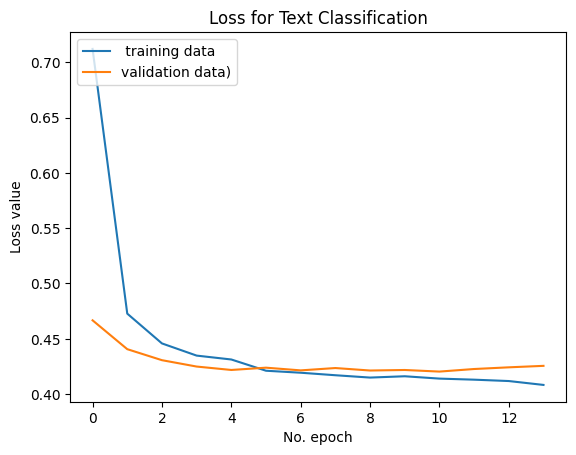

In [26]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

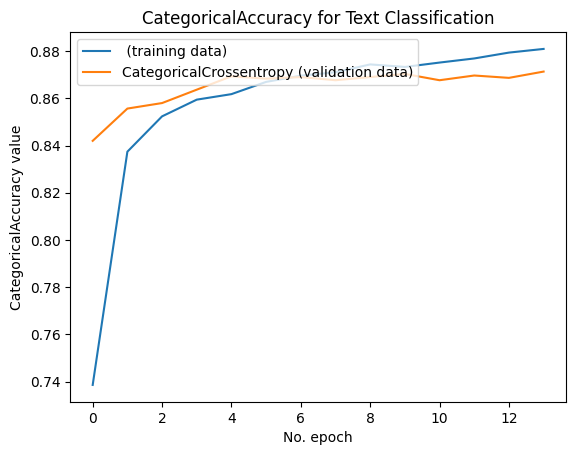

In [27]:
plt.plot(history.history['CategoricalAccuracy'], label=' (training data)')
plt.plot(history.history['val_CategoricalAccuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [28]:
model.save('/content/sample_data/tf_cnnmodel.keras')
json_string = tokenizer.to_json()

In [29]:
import json
with open('/content/sample_data/tokenizer.json', 'w') as outfile:
    json.dump(json_string, outfile)

In [30]:
new_model = tf.keras.models.load_model('/content/sample_data/tf_cnnmodel.keras')
new_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 2000, 64)            │       1,472,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 1998, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,453,641 (16.99 MB)

 Trainable params: 1,484,546 (5.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,969,095 (11.33 MB)

In [31]:
with open('/content/sample_data/tokenizer.json') as json_file:
    json_string = json.load(json_file)
tokenizer1 = tf.keras.preprocessing.text.tokenizer_from_json(json_string)

In [32]:
x_test  = tokenizer.texts_to_sequences(val_data['text'].tolist())

x_test = pad_sequences(x_test, padding='post', maxlen=2500)

x_test  = np.array(x_test)

print(x_train[0])

test_labels = le.fit_transform(val_data['label'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

[ 47 234  11 ...   0   0   0]


In [33]:

new_model.evaluate(x_train, train_labels)
loss, accuracy = new_model.evaluate(x_test, test_labels)
print("Loss:", loss)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - CategoricalAccuracy: 0.9022 - loss: 0.3761
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - CategoricalAccuracy: 0.8717 - loss: 0.4266
Loss: 0.4205927848815918
Accuracy: 0.8734999895095825
